In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, plot_results
from exp_hp import get_hp

2024-08-06 12:20:42.057549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0


### Fuctions

In [3]:
# ---------------- LEARNING RATE CALLBACK FUNCTION ----------------
# def scheduler(epoch, lr):
#     # This function keeps the initial learning rate for the first ten epochs
#     # and decreases it exponentially after that.
#     if epoch%10 != 0 or epoch == 0:
#         return lr
#     elif epoch%10 == 0 and epoch > 0:
#         return lr * tf.constant(.5,dtype=tf.float32)

In [4]:
def create_ann(input_shape, n_output, hiddens, RIDGE = 0, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    ann_input = keras.Input(shape = input_shape)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(ann_input)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(n_output,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')
    
    return ann

### Load standardized E3SM

In [5]:
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E


In [6]:
%%time
Xtrain, Xval, _, Ytrain, Yval, _, _ = split_SDbias(trainmems = hps['train_mems'],
                                                      valmem = hps['val_mems'][0],
                                                      testmem = hps['test_mems'][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD']) # 330 or 210

files do not exist - loading data & saving
CPU times: user 10.5 s, sys: 1.24 s, total: 11.7 s
Wall time: 14 s


In [7]:
Xval = Xval.reshape((Xval.shape[0],Xval.shape[1]*Xval.shape[2]))
Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]))
input_shape = Xtrain.shape[1]

### Train NN

In [11]:
# ---------- ANN Hyperparameters ----------
NLABEL = 2
N_EPOCHS = 1000

HIDDENS = hps['HIDDENS']
BATCH_SIZE = hps['BATCH_SIZE']
LR_INIT = hps['LR_INIT']
RIDGE = hps['RIDGE']
dropout_rate = hps['DROPOUT_RATE']
PATIENCE = hps['PATIENCE']
GLOBAL_SEED = hps['GLOBAL_SEED']
dropout_bool = True

In [12]:
print(HIDDENS,
      BATCH_SIZE,
      LR_INIT,
      RIDGE,
      dropout_rate,
      PATIENCE)

[128] 256 0.0001 0.0 0.9 10


0
Elapsed time during fit = 35.65 seconds



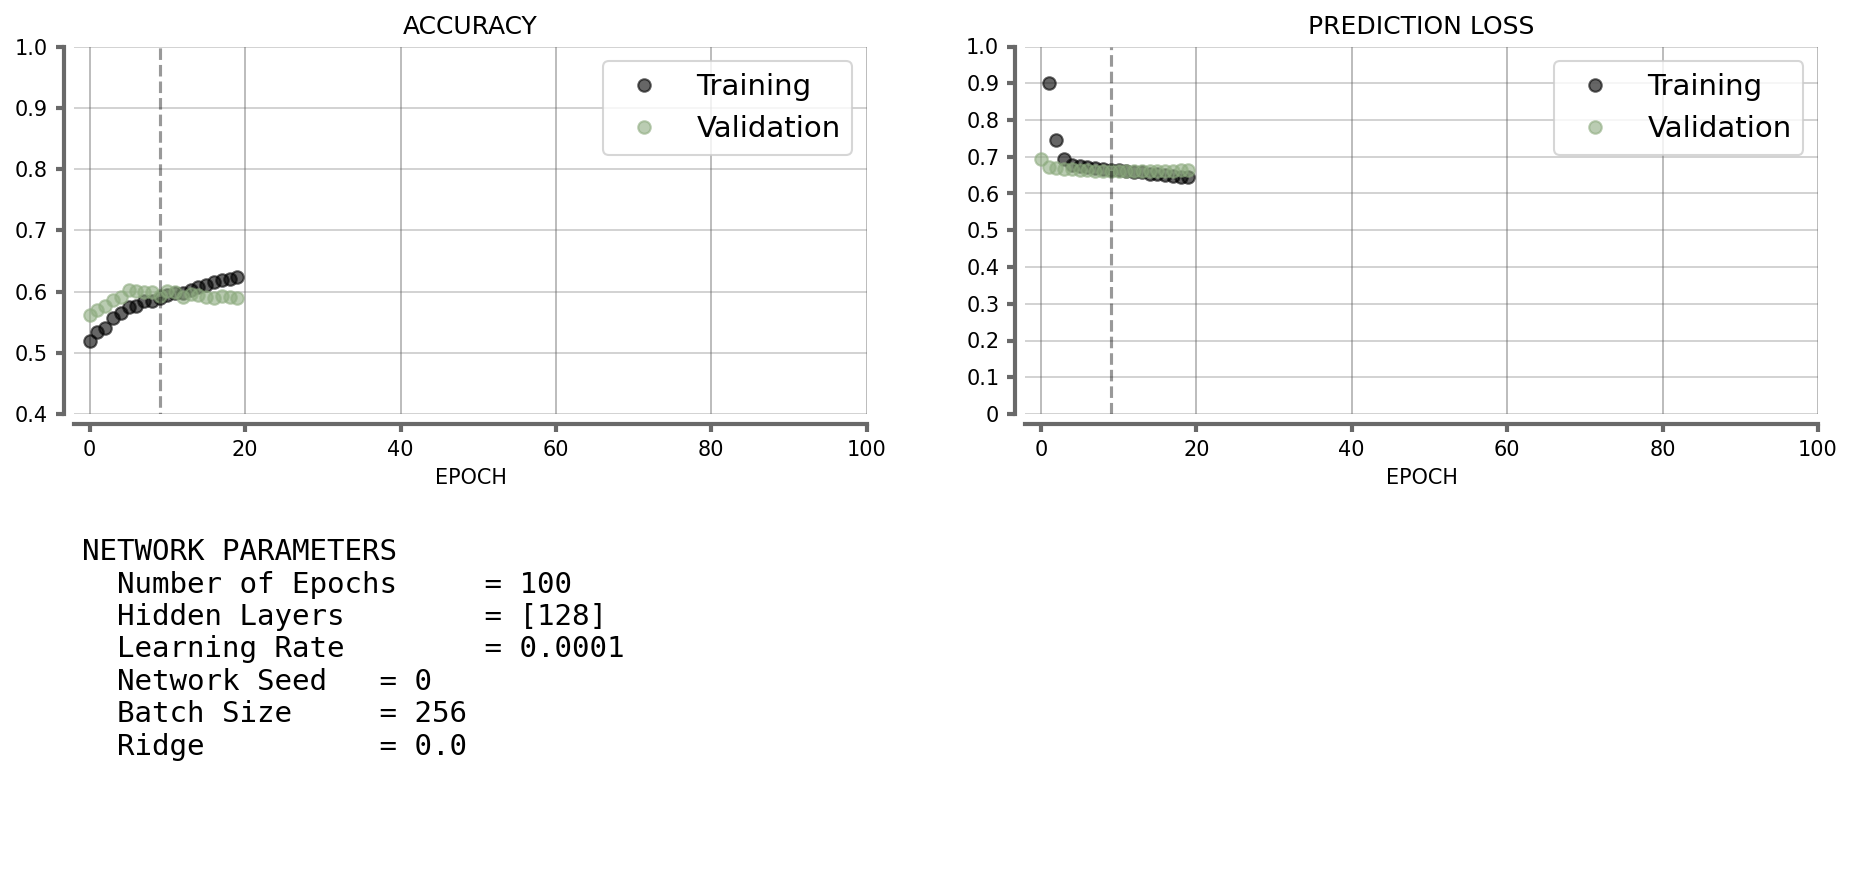

1
Elapsed time during fit = 34.24 seconds



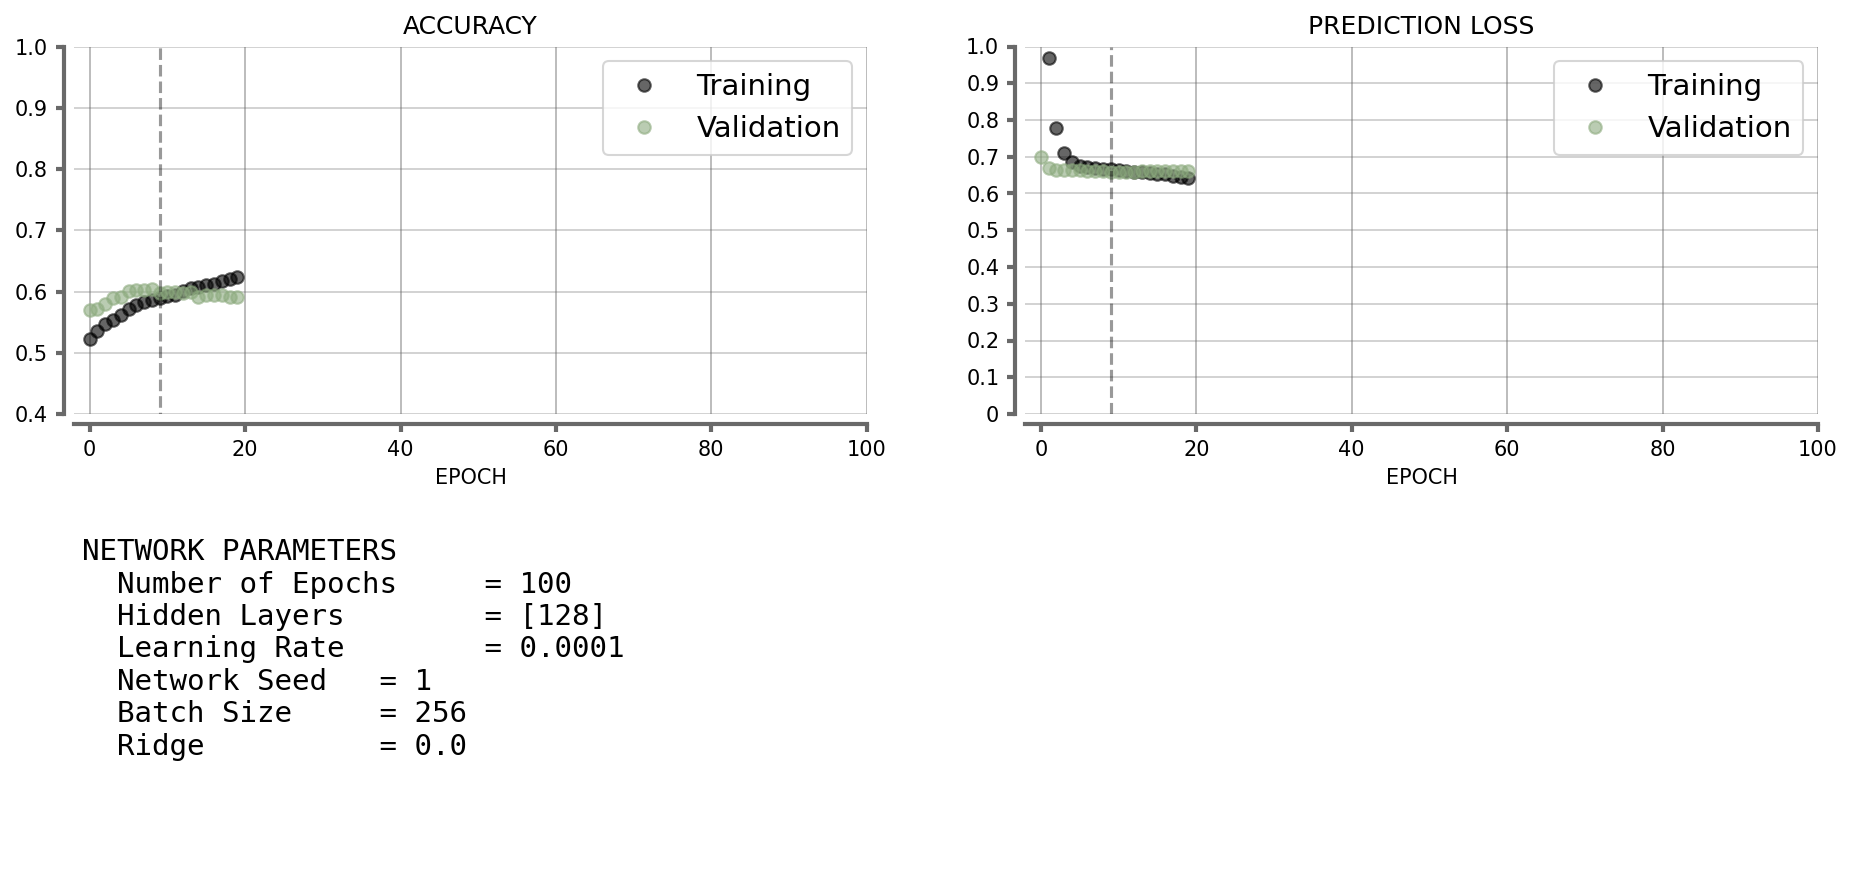

2
Elapsed time during fit = 35.91 seconds



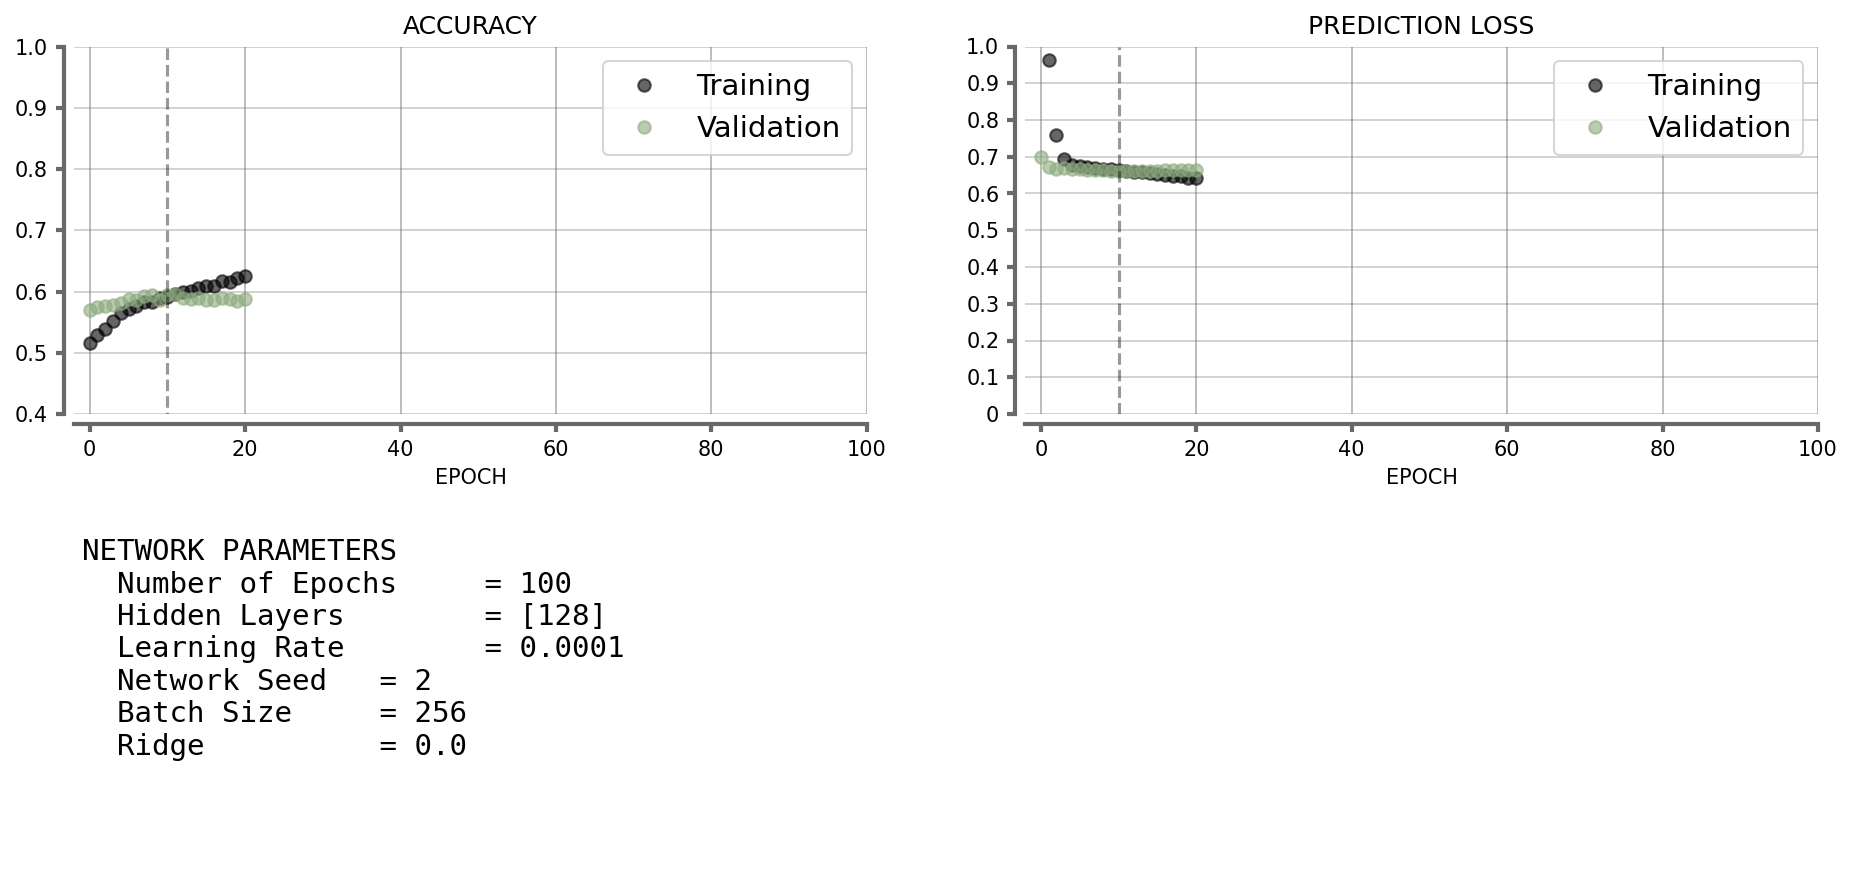

3
Elapsed time during fit = 37.61 seconds



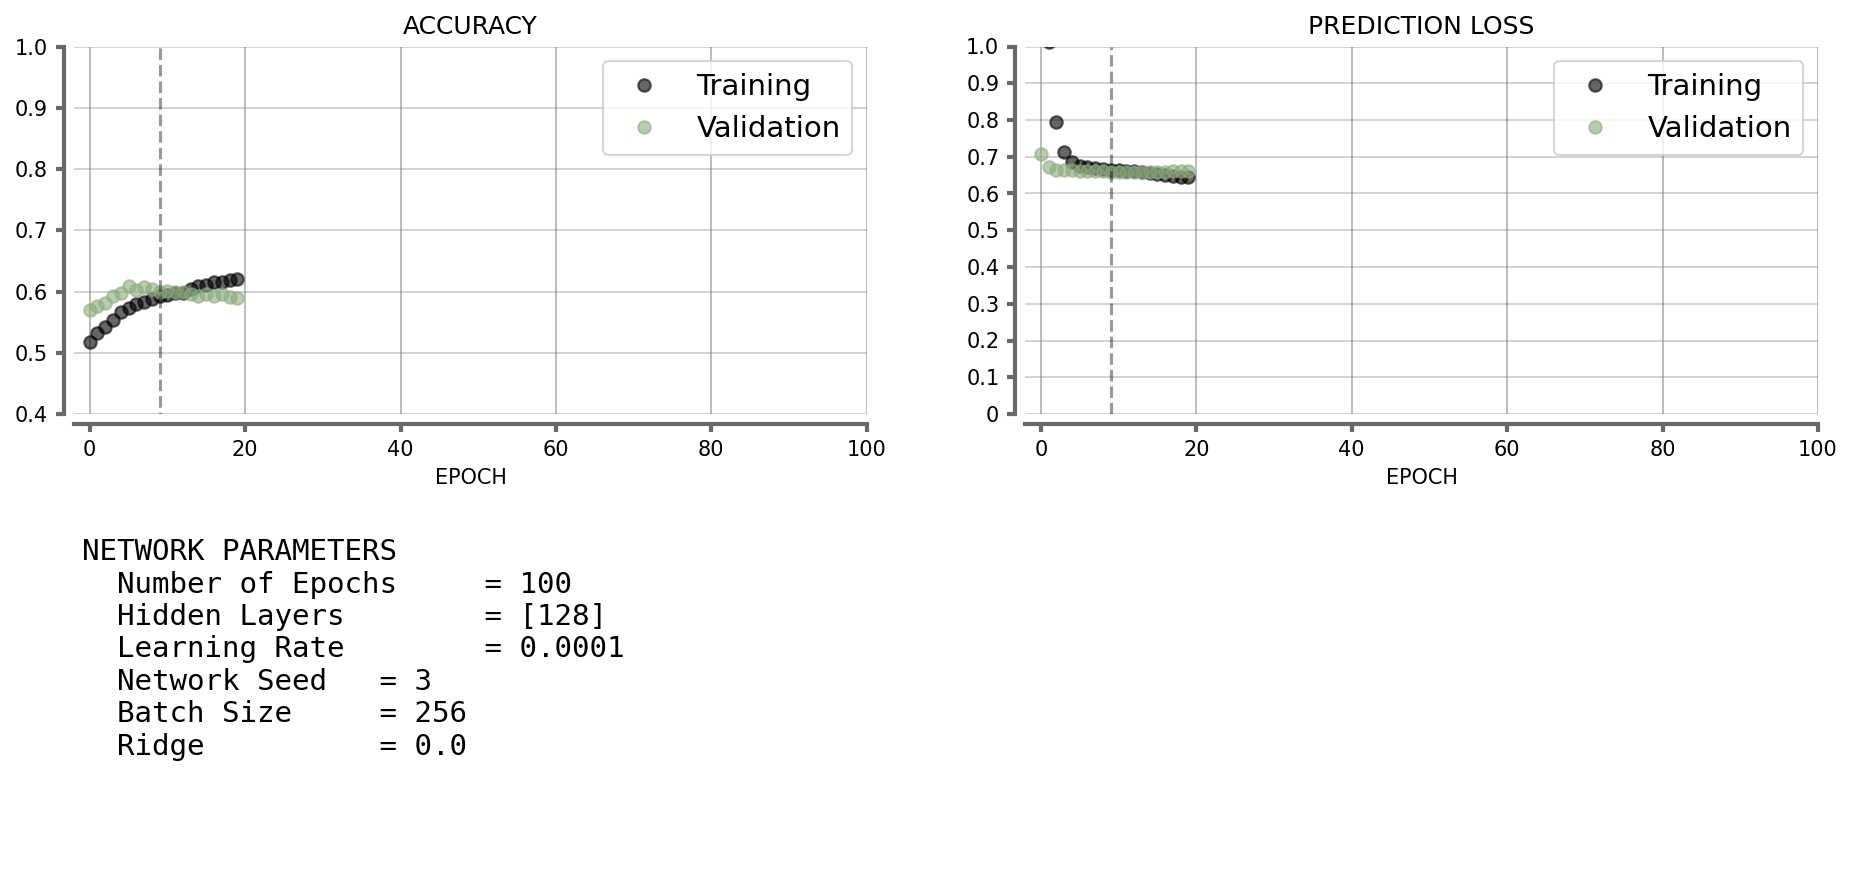

4
Elapsed time during fit = 46.24 seconds



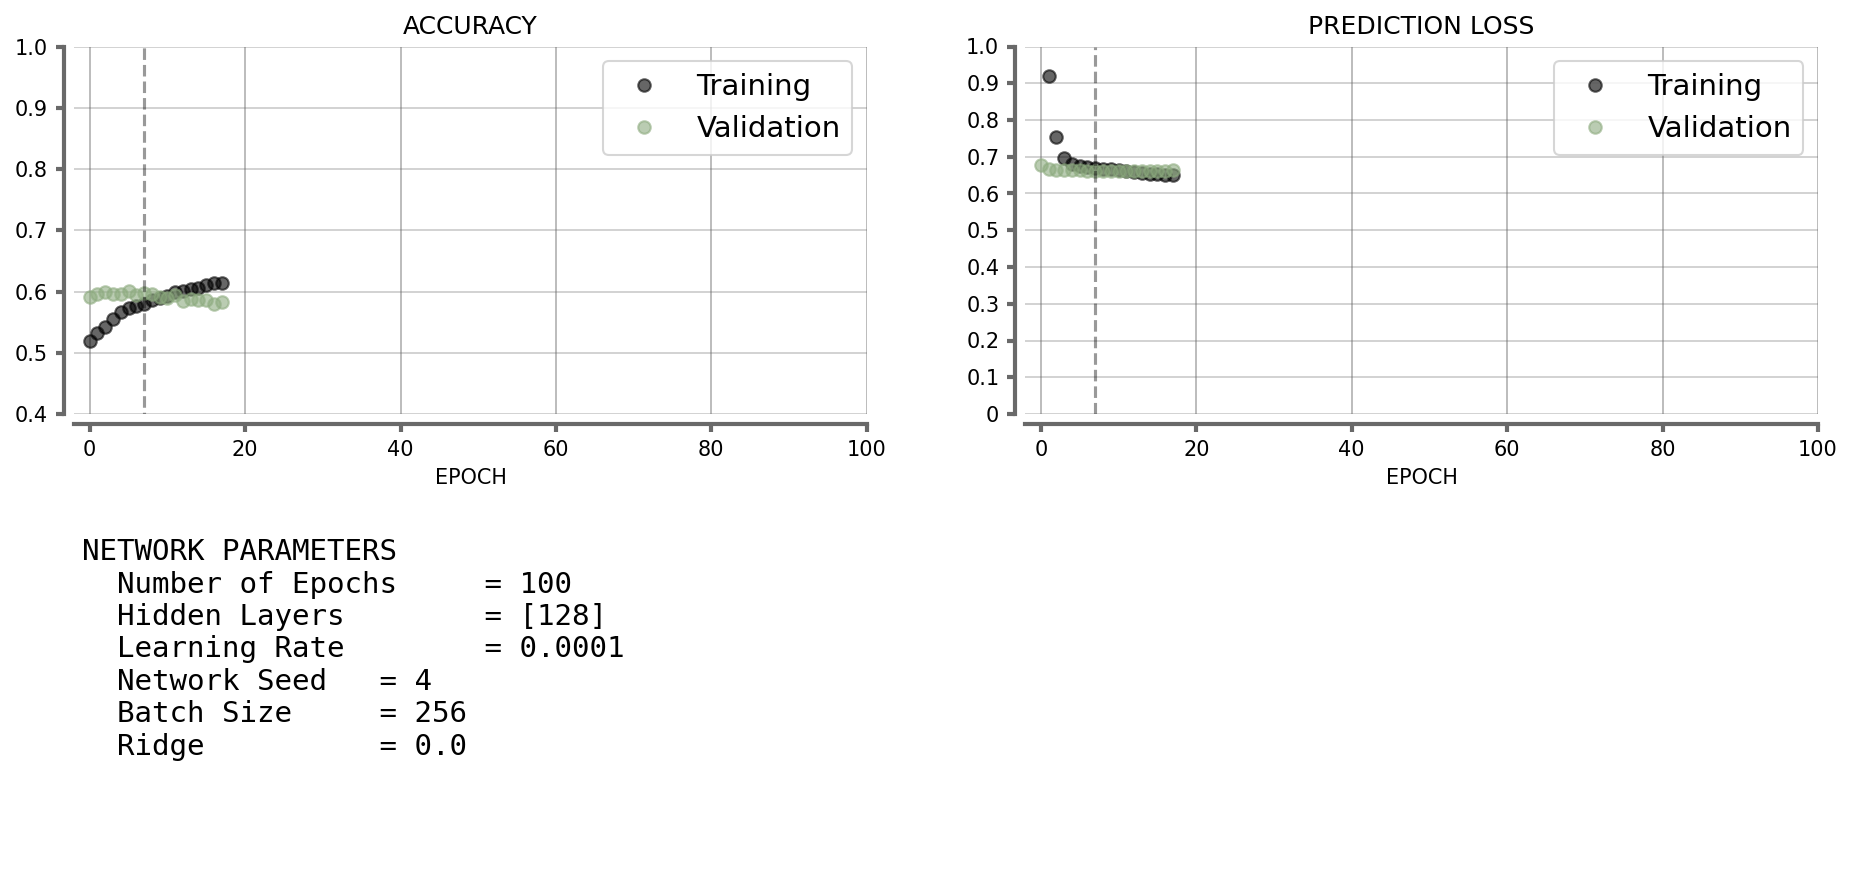

5
Elapsed time during fit = 32.86 seconds



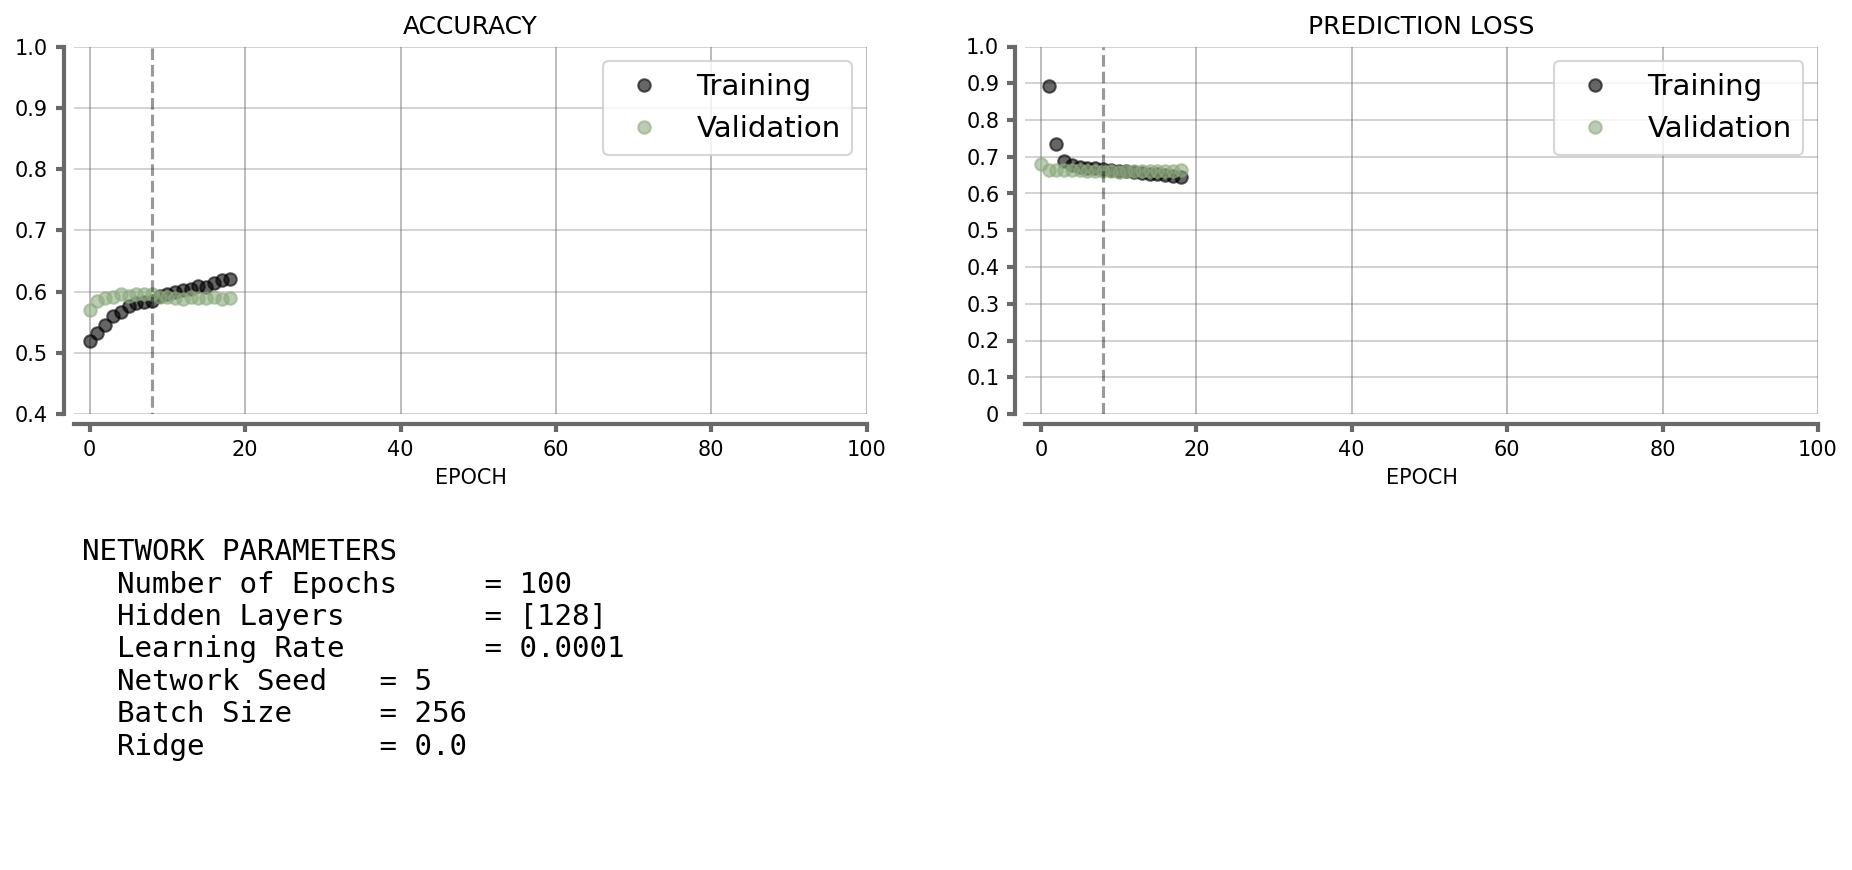

6
Elapsed time during fit = 93.36 seconds



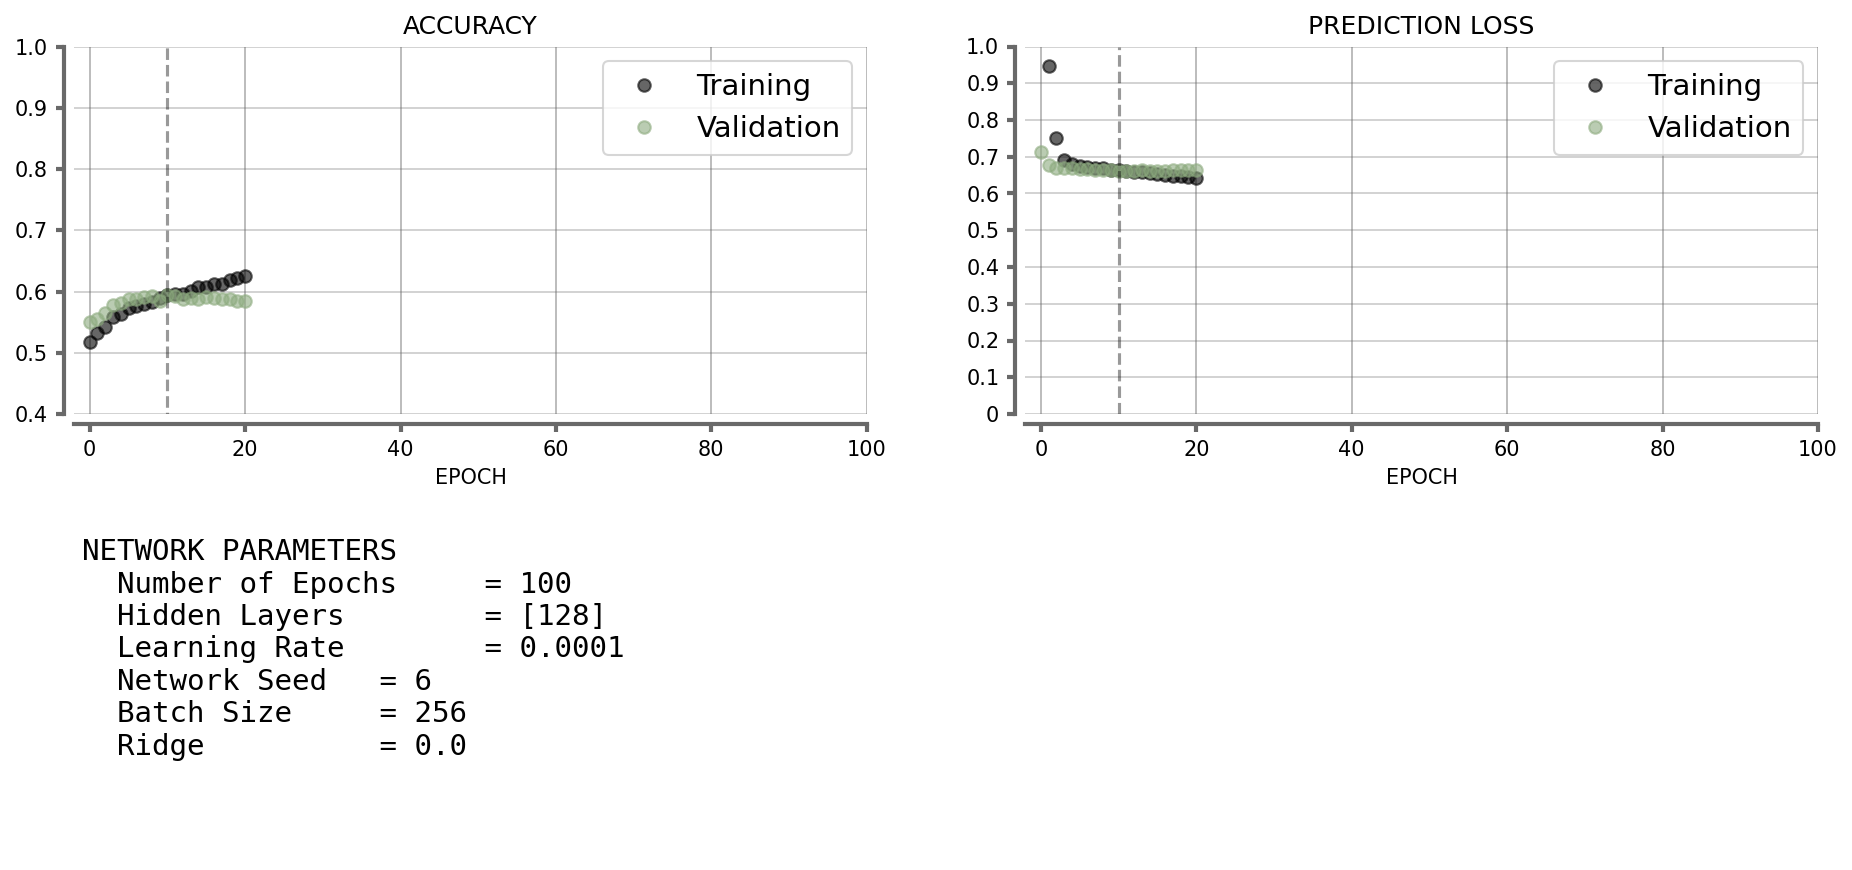

7
Elapsed time during fit = 78.80 seconds



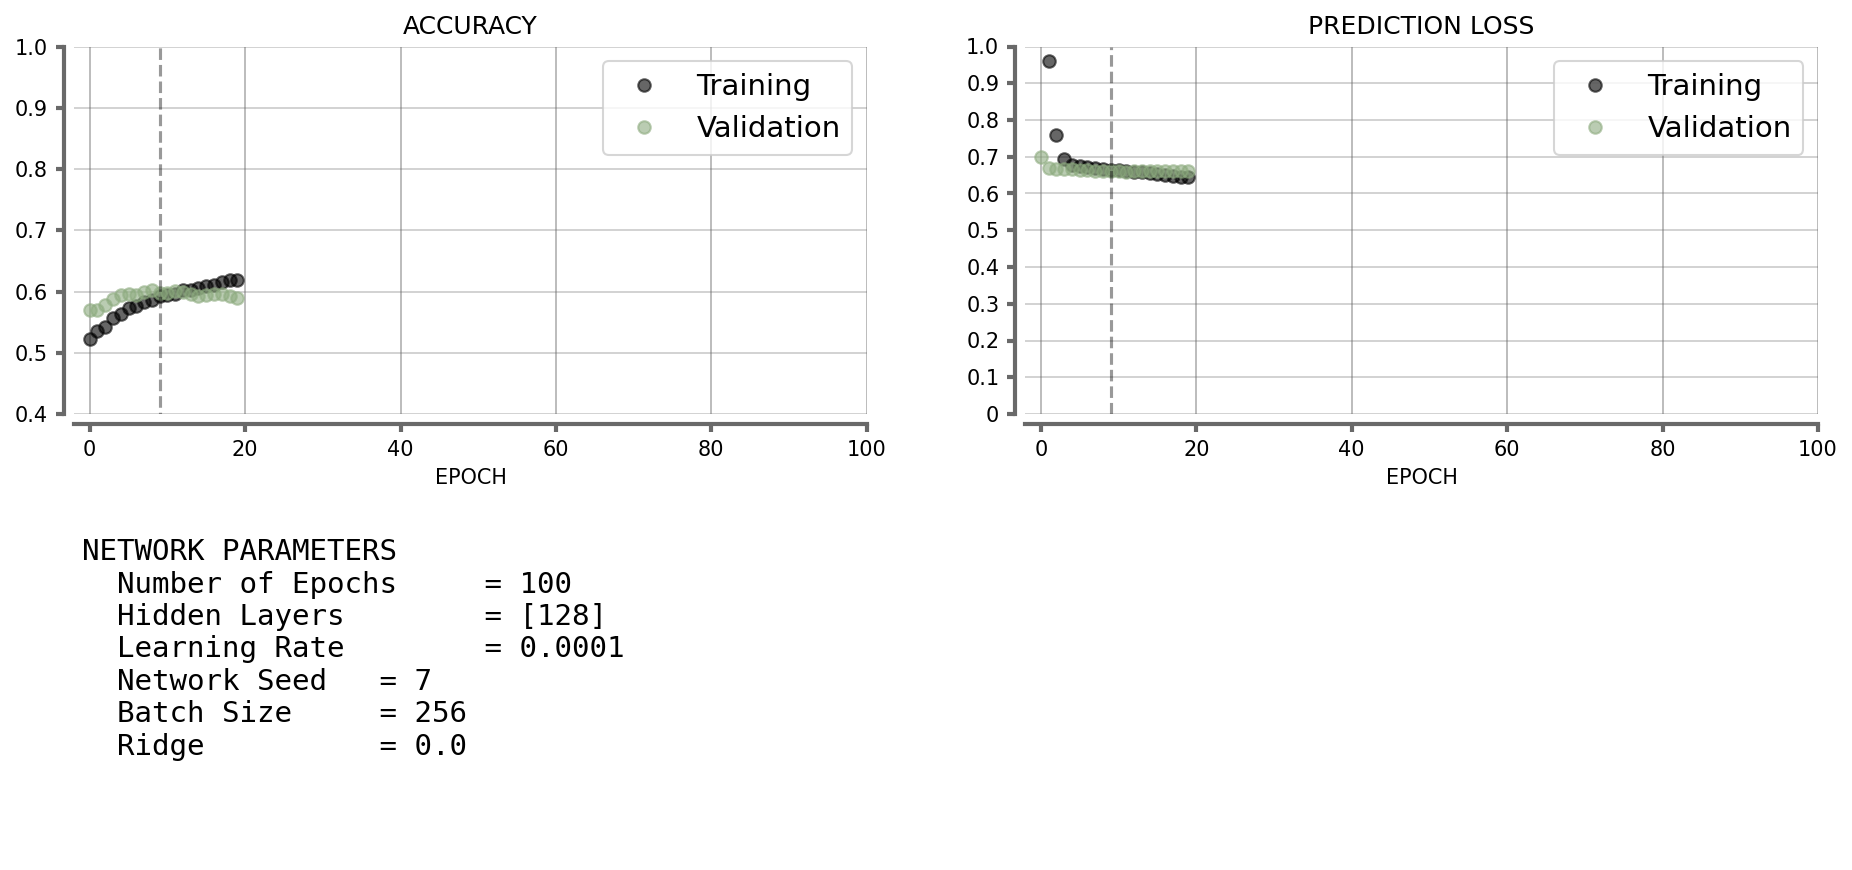

8
Elapsed time during fit = 36.68 seconds



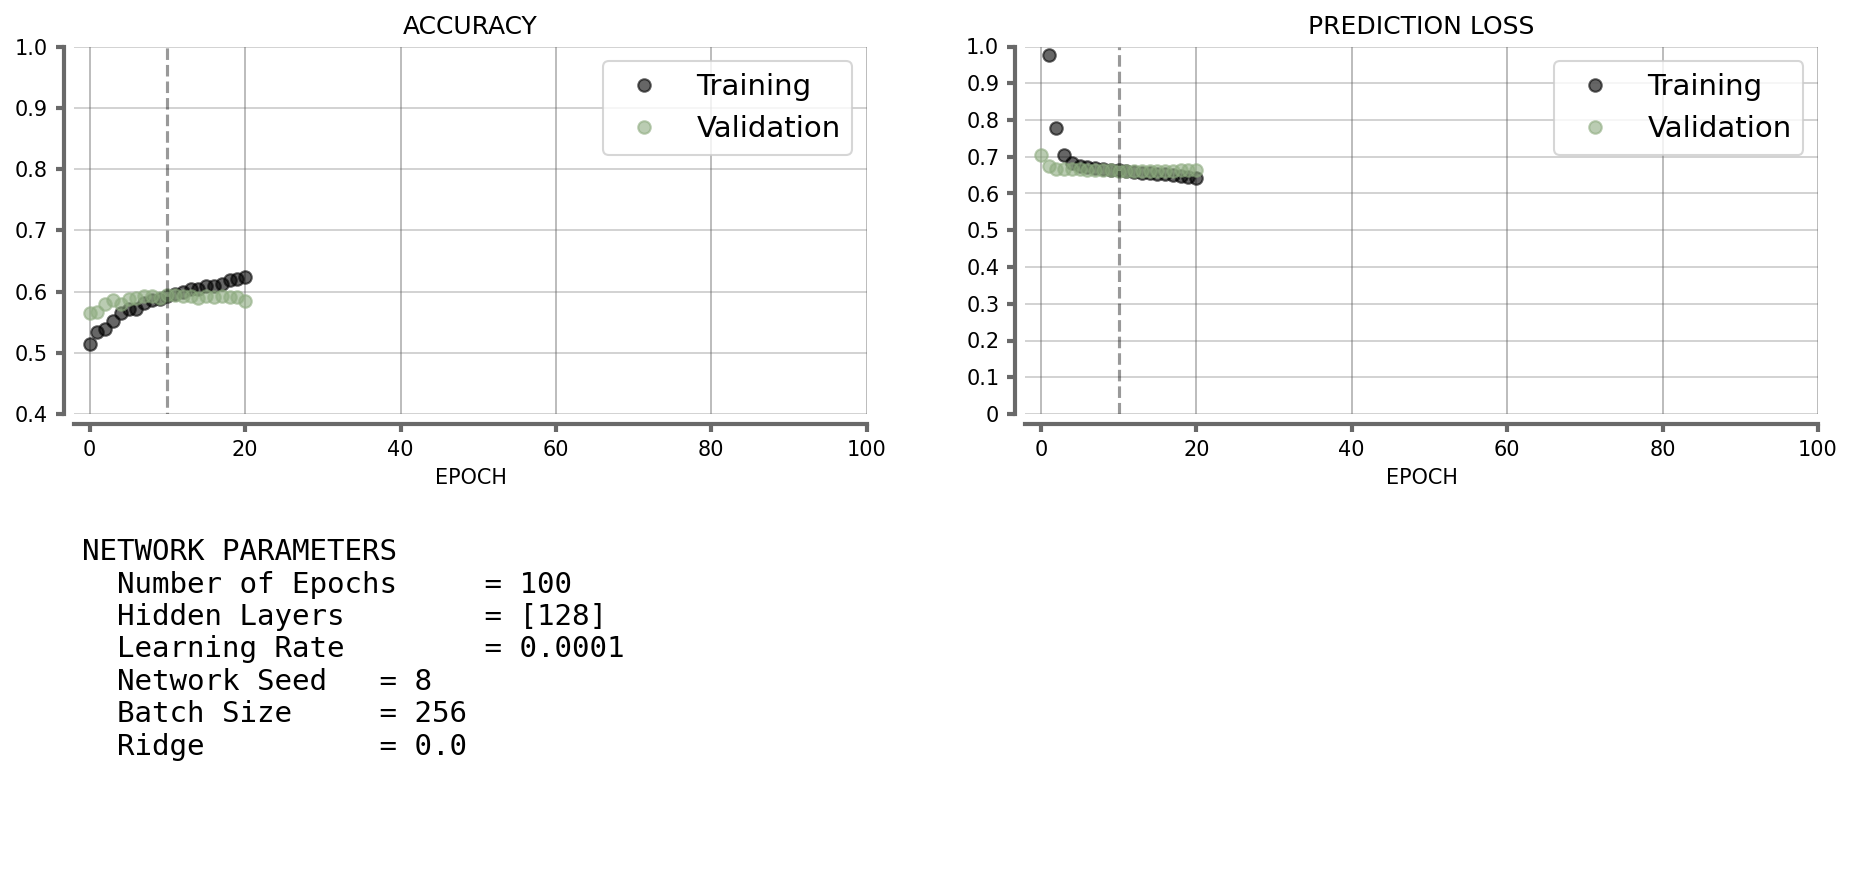

9
Elapsed time during fit = 67.93 seconds



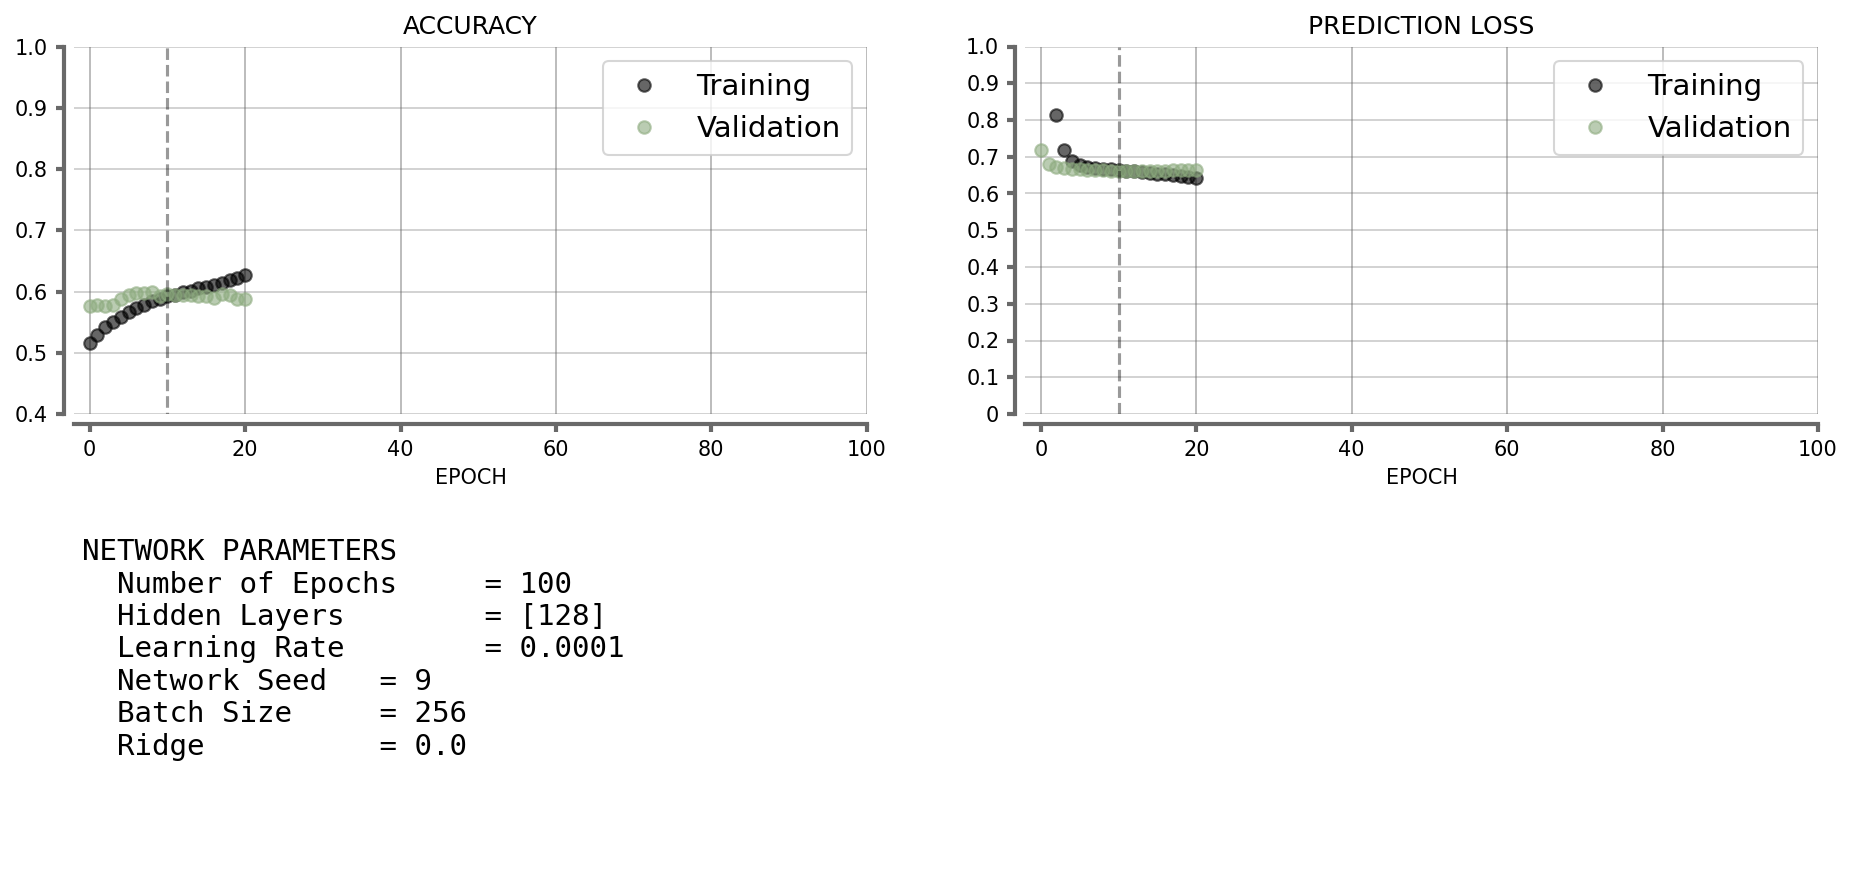

In [13]:
#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

for SEED in range(10):
    print(SEED)
    tf.keras.backend.clear_session() 

    # ------ define NN ------
    ann = create_ann(input_shape = input_shape,
                     n_output = 2,
                     hiddens=HIDDENS,
                     RIDGE = RIDGE,
                     dropout = dropout_bool, dropout_rate = dropout_rate)

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate = LR_INIT,)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    # LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)

    # ------ Train -----
    start_time = time.time()
    history = ann.fit(Xtrain,Ytrain,
                      validation_data = [Xval,Yval],
                      batch_size = BATCH_SIZE,
                      epochs = N_EPOCHS,
                      shuffle = True,
                      verbose = 0,
                      callbacks = [ES])#,LR])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")
    
    #----- PLOT THE RESULTS -----
    plot_results(
        history,
        exp_info=(100, HIDDENS, LR_INIT, BATCH_SIZE, SEED, PATIENCE, RIDGE),
        showplot=True
    ) 
    
    annfi_name = 'ann_60Eshift_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann.save(base_dir+'train/saved_models/'+annfi_name)